# Email Spam Classifier

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import string 
%matplotlib inline
import collections
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn import feature_extraction
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings('ignore')
import pickle

In [4]:
os.listdir('/Users/KBrig/ML-Pipeline')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'DecisionTreeClassifier.sav',
 'Email_Spam-checkpoint.ipynb',
 'Email_Spam.ipynb',
 'ENSampleMethodClassifier.sav',
 'flask_api',
 'LogisticRegressionClassifier.sav',
 'ML-Pipeline',
 'ML-Pipeline.ipynb',
 'NaieveBayesClassifier.sav',
 'README.md',
 'Spam.csv',
 'SVMclassifier.sav']

# Part1: Data Reading and Exploration

In [5]:
path='/Users/KBrig/ML-Pipeline/spam.csv'
#EmData= pd.read_csv('Spam.csv',encoding='cp1252')
EmData= pd.read_csv(path,encoding='cp1252',dtype={'type':np.str, 'Email_body':np.str})

In [6]:
EmData.head()

,type,Email_body,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
EmData=EmData[['type','Email_body']]

In [8]:
#print(EmData.shape)
for col in EmData.columns:
    print ('column', col,':', type(col[0]))

column type : <class 'str'>
column Email_body : <class 'str'>


In [9]:
EmData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
type          5572 non-null object
Email_body    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [10]:
EmData.groupby('type').describe()

Email_body                                                               
          count unique                                                top freq
type                                                                          
ham        4825   4516                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

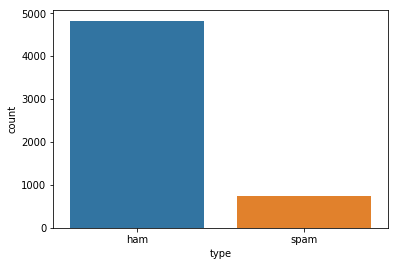

In [11]:
sns.countplot(x='type',data=EmData)

In [12]:
#EmData['y']=EmData['type'].apply(lambda x: x =='spam').astype(int)
EmData['type_num']= EmData.type.map({'ham':0, 'spam':1})

In [13]:
EmData.head()

,type,Email_body,type_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [14]:
EmData['lngth']= EmData['Email_body'].apply(len)

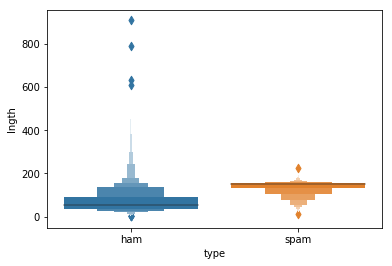

In [15]:
sns.boxenplot(x='type',y='lngth', data=EmData)





# Part2: Data Splitting


In [12]:
X = EmData.Email_body
y= EmData.type_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [13]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)


In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)





# Part3: Feature Engineering

Feature Extraction with default values of "CountVectorizer" and "English" stop words

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
def pip(classifier):
    #SW = set(stopwords.words('english'))
    pipeline = Pipeline([
        ('vect', CountVectorizer()),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('clf', classifier),
    ])
    return(pipeline)
        

In [16]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(2, 3))
#features = tfidf.fit_transform(X_train)
#pd.DataFrame(
 #   features.todense(),
  #  columns=tfidf.get_feature_names())
#tfidf.get_feature_names()




# Part4: Model Building



# Naieve Bayes Classifier 

In [17]:
from sklearn.naive_bayes import MultinomialNB
pip_NB= pip(MultinomialNB(fit_prior=False))

Data Training

In [18]:
pip_NB.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...near_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False))])

Saving NB model

In [19]:
# save the model to disk
filename = 'NaieveBayesClassifier.sav'
pickle.dump(pip_NB, open(filename, 'wb'))



Testing NB Model

In [20]:
predictions_NB = pip_NB.predict(X_test)

Model Performance Metrics

In [21]:
print(classification_report(predictions_NB,y_test))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      1471
          1       0.87      0.94      0.90       201

avg / total       0.98      0.98      0.98      1672



In [22]:
NB_roc_auc_score=roc_auc_score(y_test,predictions_NB)
NB_roc_auc_score

0.9293596910768144

# Logistic Regression Classifier

In [23]:
from sklearn.linear_model import LogisticRegression
pip_LR= pip(LogisticRegression(random_state=0))

Data Training 

In [24]:
pip_LR.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Saving LR model

In [25]:
filename = 'LogisticRegressionClassifier.sav'
pickle.dump(pip_LR, open(filename, 'wb'))

Testing LR Model

In [26]:
predictions_LR = pip_LR.predict(X_test)

Model Performance Metrics

In [27]:
print(classification_report(predictions_LR,y_test))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98      1497
          1       0.79      0.99      0.88       175

avg / total       0.98      0.97      0.97      1672



In [28]:
#ROC score
LR_roc_auc_score=roc_auc_score(y_test,predictions_LR)
LR_roc_auc_score

0.8961012329164721




# SVM Classifier

In [29]:
from sklearn.linear_model import SGDClassifier
pip_SVM= pip(SGDClassifier(random_state=0))

In [30]:
pip_SVM.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...lty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [31]:
filename = 'SVMclassifier.sav'
pickle.dump(pip_SVM, open(filename, 'wb'))

In [32]:
predictions_SVM = pip_SVM.predict(X_test)

In [33]:
print(classification_report(predictions_SVM,y_test))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99      1470
          1       0.91      0.99      0.95       202

avg / total       0.99      0.99      0.99      1672



In [34]:
SVM_roc_auc_score=roc_auc_score(y_test,predictions_SVM)
SVM_roc_auc_score

0.9553903814847999




# Decision Trees Classifier 

In [35]:
from sklearn import tree
pip_DT=pip(tree.DecisionTreeClassifier())

In [36]:
pip_DT.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [37]:
filename = 'DecisionTreeClassifier.sav'
pickle.dump(pip_DT, open(filename, 'wb'))

In [38]:
predictions_DT = pip_DT.predict(X_test)

In [39]:
print(classification_report(predictions_DT,y_test))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1452
          1       0.86      0.85      0.85       220

avg / total       0.96      0.96      0.96      1672



In [40]:
DT_roc_auc_score=roc_auc_score(y_test,predictions_DT)
DT_roc_auc_score

0.917551077066744



# Ensamble Methods Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
pip_EM = pip(RandomForestClassifier(n_estimators=10))

In [42]:
pip_EM.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [43]:
filename = 'ENSampleMethodClassifier.sav'
pickle.dump(pip_EM, open(filename, 'wb'))

In [44]:
predictions_EM = pip_EM.predict(X_test)

In [45]:
print(classification_report(predictions_EM,y_test))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98      1503
          1       0.77      0.99      0.87       169

avg / total       0.98      0.97      0.97      1672



In [46]:
EM_roc_auc_score=roc_auc_score(y_test,predictions_EM)
EM_roc_auc_score

0.8849772219628232



# Comparing the accuracy of different ML models 

In [47]:
accuracy=[NB_roc_auc_score,LR_roc_auc_score,SVM_roc_auc_score,DT_roc_auc_score,EM_roc_auc_score]
accuracy

[0.9293596910768144,
 0.8961012329164721,
 0.9553903814847999,
 0.917551077066744,
 0.8849772219628232]

In [48]:
models= ["NB", "LR", "SVM", "DT", "EM"]
models


['NB', 'LR', 'SVM', 'DT', 'EM']

In [49]:
d = {'model': models,'accuracy': accuracy}

In [50]:
Performane = pd.DataFrame(data=d)
Performane

,model,accuracy
0,NB,0.929360
1,LR,0.896101
2,SVM,0.955390
3,DT,0.917551
4,EM,0.884977


Text(0.5,1,'Comparing the Accuracy of Different ML Models')

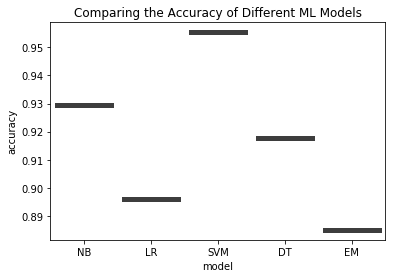

In [51]:
ax=sns.boxplot(x='model', y='accuracy', data=Performane,linewidth=5)
ax.set_title("Comparing the Accuracy of Different ML Models")




# Model Tuning with Cross Validation

In [52]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pip_SVM, X_train, y_train, scoring='accuracy', cv=5)


In [53]:
model_pip= [MultinomialNB(), LogisticRegression(random_state=0), SGDClassifier(random_state=0), tree.DecisionTreeClassifier(), RandomForestClassifier(n_estimators=10)]

In [54]:
scores.mean()

0.9874375322436217

In [55]:
Acc_with_CV=[]
for l in model_pip:
    Acc_with_CV.append (cross_val_score(pip(l), X_train, y_train, scoring='roc_auc', cv=5).mean())
print(Acc_with_CV)
  

[0.9841969204281504, 0.9893758959916511, 0.9915618309408132, 0.8948630615786991, 0.9811047809228761]


In [56]:
Performane['Accuracy_with_CV']=Acc_with_CV

In [57]:
Performane.head()

,model,accuracy,Accuracy_with_CV
0,NB,0.929360,0.984197
1,LR,0.896101,0.989376
2,SVM,0.955390,0.991562
3,DT,0.917551,0.894863
4,EM,0.884977,0.981105


In [58]:
##STEMMING

#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer("english", ignore_stopwords=True)

#class StemmedCountVectorizer(CountVectorizer):
#    def build_analyzer(self):
#        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
#        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

#stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

#text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
#                            ('tfidf', TfidfTransformer()),
 #                            ('mnb', MultinomialNB()),
  #                          ])

#text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)

#predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)

#np.mean(predicted_mnb_stemmed == y_test)




# Parameters Tuning with GridSearchCV

Comparing differnt parameters, e.g. comparing the performance of NB with unigram and Bigram 

In [65]:
from sklearn.model_selection import GridSearchCV

In [77]:
 parameters_NB = {'vect__ngram_range': [(1, 2), (2, 3)],
                  'vect__analyzer':['word','char'],
                  'tfidf__use_idf': (True, False),
                  'clf__alpha': (1e-2, 1e-3),
                 }

In [78]:
gs_clf_NB = GridSearchCV(pip(MultinomialNB(fit_prior=False)), parameters_NB, n_jobs=-1)

In [79]:
gs_clf_NB = gs_clf_NB.fit(X_train, y_train)

In [80]:
gs_clf_NB.best_score_


0.9874358974358974

In [81]:
gs_clf_NB.best_params_

{'clf__alpha': 0.01,
 'tfidf__use_idf': True,
 'vect__analyzer': 'char',
 'vect__ngram_range': (2, 3)}